## Hecho por: David Ramírez Betancourth
## C.C. 1002636667
## Ingeniería Electrónica
## Universidad Nacional de Colombia Sede Manizales

In [82]:
import matplotlib.pyplot as plt #Graficador
import numpy as np #Opearciones entre arrays
import scipy.signal as sig #métodos de señales (welch)
import scipy.stats as stats


import tensorflow as tf # Red Neuronal
from sklearn.model_selection import train_test_split #Divisor de datos de entrenamiento y testeo
from sklearn.preprocessing import MinMaxScaler #Normalizador de escala
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential #Red Neuronal
from tensorflow.keras.layers import Dense, Dropout #Conexión neuronas
from tensorflow.keras.optimizers import Adam #Optimizador de red

#Generar Señal

$f_o = 1 Hz$

$x(t) = cos(\omega_o) - \frac{sin(3\omega_o)}{3} + \frac{cos(5\omega_o)}{5}$

$\xi(t) = x(t) + \eta(t)$

Aplicar método welch: Consiste en hallar la FFT por ventaneos de la señal y luego promediando las PSD de cada segmento

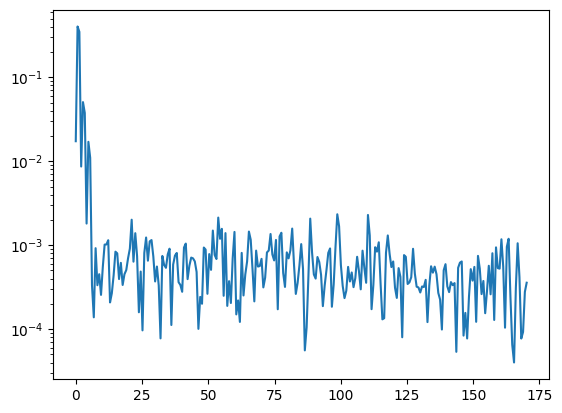

In [83]:
np.random.seed(0)

def randomvector(N, sigma):
    """Genera un vector gaussiano eta = N(0, sigma)"""

    return np.random.normal(0, np.sqrt(sigma), size=N) 

def real_signal(t, wo):
    """x(t)"""

    return np.cos(wo*t) - (1/3)*np.sin(3*wo*t) + (1/5)*np.cos(5*wo*t)


def welch_vector(X, fs, nperseg):
    """Generar psd de la señal xi
       ventaneo hamming
       overlap del 25% de la vetana
    """

    return sig.welch(X, fs, window='hamming', nperseg=nperseg, noverlap=(nperseg*.25))

N = 1024 #Longitud señal
M = 1000 # No de señales
fo = 1 # 1Hz frecuencia
wo = 2*np.pi*fo
sigma = 0.1  #varianza
nperseg = 501 #Longitud ventana

t = np.linspace(0, 3, N) # vector de tiempo de 0 a 3 segundos
fs = 1/(t[1]-t[0]) #Muestreo

X = np.zeros((M, N)) #Matriz vacía de zeros
for i in range(M):
    X_true = real_signal(t, wo) #Generar señal real
    X[i] = X_true + randomvector(N, sigma) #Combinarla con ruido, meterla a la fila

Psd_real = np.zeros((M, (nperseg//2)+1)) # Matriz welch, M señales, longitud psd = (ventaneo//2) +1
for i in range(M):
    f, psd = welch_vector(X[i], fs, nperseg)
    Psd_real[i] = psd


plt.semilogy(f, Psd_real[100])
plt.show()

# Preparar Datos

Scaler: normaliza los datos a una escala deseada (0,1)

train test split: Divide los datos un porcentaje deseado 70/30, 70 entrenar, 30 test.

In [84]:
scaler = MinMaxScaler(feature_range=(0, 1))

X_scaled = scaler.fit_transform(X)
Psd_scaled = scaler.fit_transform(Psd_real)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Psd_scaled, test_size=0.3, random_state=42)

# Red Neuronal

Modelo tipo Sequential(MLP): Las capas se apilan una tras otra, lo que hace que el flujo de datos sea simple y directo. Es MLP porque contiene perceptrones. Capa de entrada - capa oculta - capa de salida. Configuración Dense.

Optimizador Adam: Utiliza AdaGrad y RMSProp. Consiste en:
- Calcular Gradiente
- Se corrige sesgos
- Se actualizan pesos
 



In [85]:
model = Sequential([
    tf.keras.Input(shape=(N,)), #Capa de entrada
    Dense(N//2, activation='relu'), #Capa oculta
    Dropout(0.5), #Dropout para no sobreajuste
    Dense(N//4, activation='relu'), # Capa oculta
    Dense(128, activation='relu'), #Capa oculta
    Dense(nperseg//2 + 1) #Capa de salida
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['accuracy']) #Optimizador adam, 

history = model.fit(X_train, y_train, epochs=50, validation_split=0.2)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.0085 - loss: 0.1342 - val_accuracy: 0.0071 - val_loss: 0.0628
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0045 - loss: 0.0670 - val_accuracy: 0.0000e+00 - val_loss: 0.0568
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0094 - loss: 0.0588 - val_accuracy: 0.0214 - val_loss: 0.0500
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0183 - loss: 0.0524 - val_accuracy: 0.0286 - val_loss: 0.0432
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0082 - loss: 0.0446 - val_accuracy: 0.0286 - val_loss: 0.0369
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0188 - loss: 0.0386 - val_accuracy: 0.0286 - val_loss: 0.0320
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0193 - loss: 0.0338 - val_accuracy: 0.0286 - val_loss: 0.0284
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0206 - loss: 0.0305 - val_accuracy: 0.0286

In [86]:
sigma = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,  0.8, 0.9, 1, 5, 10]

mse_vector = np.zeros(len(sigma))
mae_vector = np.zeros(len(sigma))

for j in range(len(sigma)):
    X = np.zeros((M, N)) #Matriz vacía de zeros
    for i in range(M):
        X_true = real_signal(t, wo) #Generar señal real
        X[i] = X_true + randomvector(N, sigma[j]) #Combinarla con ruido, meterla a la fila

    Psd_real = np.zeros((M, (nperseg//2)+1)) # Matriz welch, M señales, longitud psd = (ventaneo//2) +1
    for i in range(M):
        f, psd = welch_vector(X[i], fs, nperseg)
        Psd_real[i] = psd

    scaler = MinMaxScaler(feature_range=(0, 1))

    X_scaled = scaler.fit_transform(X)
    Psd_scaled = scaler.fit_transform(Psd_real)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, Psd_scaled, test_size=0.3, random_state=42)

    history = model.fit(X_train, y_train, epochs=40, validation_split=0.2)

    psd_pred_scaled = model.predict(X_scaled)
    psd_pred = scaler.inverse_transform(psd_pred_scaled)

    mse_per_signal = np.zeros(M)
    mae_per_signal = np.zeros(M)
    for k in range(M):
        mse_per_signal[k] = mean_squared_error(psd_pred[k], Psd_real[k])
        mae_per_signal[k] = mean_absolute_error(psd_pred[k], Psd_real[k])




    mse_vector[j] = np.mean(mse_per_signal)
    mae_vector[j] = np.mean(mae_per_signal)


Epoch 1/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0000e+00 - loss: 0.0023 - val_accuracy: 0.0000e+00 - val_loss: 0.0017
Epoch 2/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0000e+00 - loss: 0.0016 - val_accuracy: 0.0000e+00 - val_loss: 0.0012
Epoch 3/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0000e+00 - loss: 0.0011 - val_accuracy: 0.0000e+00 - val_loss: 8.0339e-04
Epoch 4/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0000e+00 - loss: 7.4498e-04 - val_accuracy: 0.0000e+00 - val_loss: 5.9296e-04
Epoch 5/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0000e+00 - loss: 5.5399e-04 - val_accuracy: 0.0000e+00 - val_loss: 4.4882e-04
Epoch 6/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0000e+00 - loss: 4.2087e-04 - val_accuracy: 0.0000e+00 - val_loss: 3.4446e-04
Epoch 7/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0000e+00 - loss: 3.2382e-04 - val_accuracy: 0.0000e+00 - val_loss: 2.6728e-04
Epoch 8/40
18/18 ━━━━━━━━

<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\s'
C:\Users\david\AppData\Local\Temp\ipykernel_14272\2742380796.py:10: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('$\sigma^2$')


Varianza: 0   MSE: 4.879556088736236e-06   MAE:0.0013844055059499454
Varianza: 0.1   MSE: 2.101695876184971e-06   MAE:0.00045582357124898686
Varianza: 0.2   MSE: 5.4360578850421695e-06   MAE:0.0008361559030951189
Varianza: 0.3   MSE: 9.286027040664464e-06   MAE:0.0012074535632567822
Varianza: 0.4   MSE: 1.1966466376101805e-05   MAE:0.0015292827487093927
Varianza: 0.5   MSE: 1.3161780055739786e-05   MAE:0.0018661317593096955
Varianza: 0.6   MSE: 1.6925898547981597e-05   MAE:0.0022127019686620873
Varianza: 0.7   MSE: 2.1201779341299014e-05   MAE:0.0025545650281489536
Varianza: 0.8   MSE: 2.5853241759539506e-05   MAE:0.0028970763778821506
Varianza: 0.9   MSE: 2.9862013282077688e-05   MAE:0.003210358985449589
Varianza: 1   MSE: 3.454792844585259e-05   MAE:0.0035491673783424474
Varianza: 5   MSE: 0.0005132634876515783   MAE:0.016469029193326462
Varianza: 10   MSE: 0.0018832245511685992   MAE:0.032533549378712175


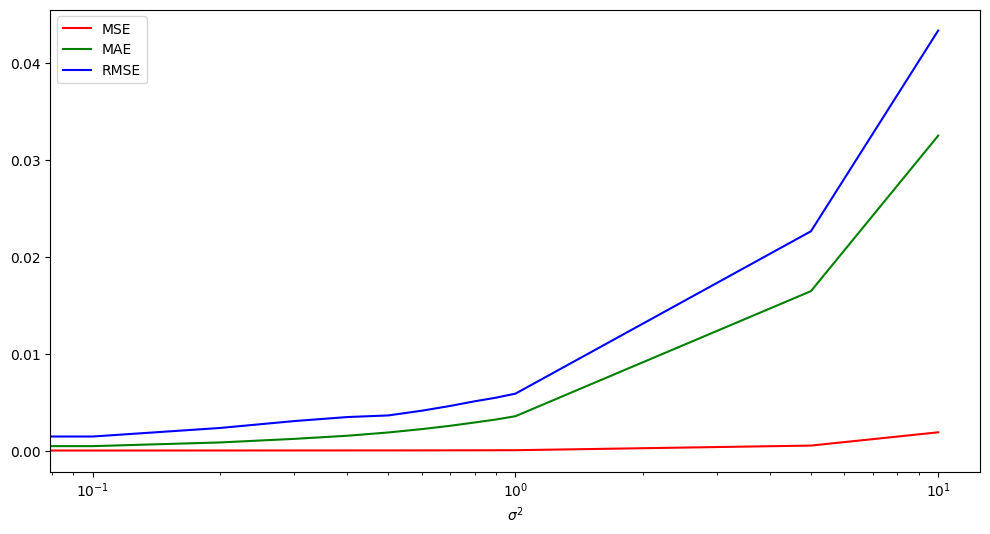

In [87]:
for i in range(len(sigma)):
    print(f"Varianza: {sigma[i]}   MSE: {mse_vector[i]}   MAE:{mae_vector[i]}")

rmse_vector = np.sqrt(mse_vector)

plt.figure(figsize=(12,6))
plt.semilogx(sigma, mse_vector, c='r', label='MSE')
plt.semilogx(sigma, mae_vector, c='g', label='MAE')
plt.semilogx(sigma, rmse_vector, c='b', label='RMSE')
plt.xlabel('$\sigma^2$')
plt.legend()
plt.show()


# Rendimiento del Modelo

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0165 - loss: 0.0223 
Test Loss: 0.022121138870716095, Test MAE: 0.01666666753590107


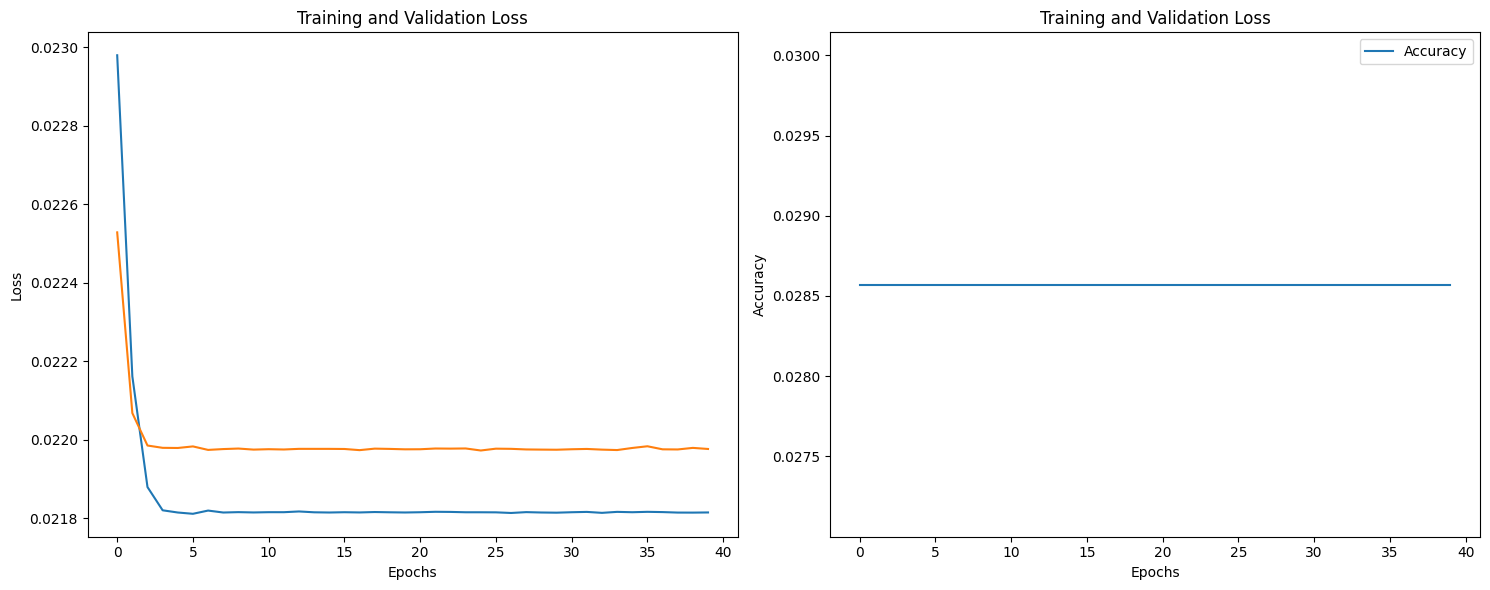

In [88]:
# Evaluar modelo
loss, mae = model.evaluate(X_test, y_test) #Saca mae = promedio del error absoluto y pérdidas del modelo
print(f"Test Loss: {loss}, Test MAE: {mae}")


fig, axs = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(15, 6)
axs[0].plot(history.history['loss'], label='Training Loss')
axs[0].plot(history.history['val_loss'], label='Validation Loss')
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[1].plot(history.history['accuracy'], label='Accuracy')
axs[1].set_title('Training and Validation Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Predecir

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


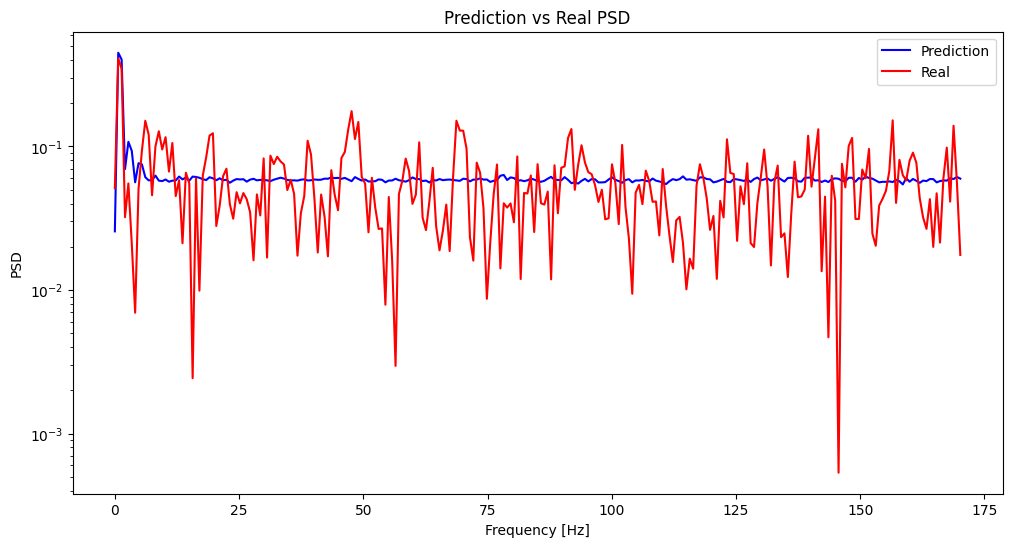

In [89]:
psd_pred_scaled = model.predict(X_scaled)
psd_pred = scaler.inverse_transform(psd_pred_scaled)

plt.figure(figsize=(12, 6))
plt.semilogy(f, psd_pred[50], color='b', label='Prediction')
plt.semilogy(f, Psd_real[50], color='r', label='Real')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD')
plt.title('Prediction vs Real PSD')
plt.legend()
plt.show()

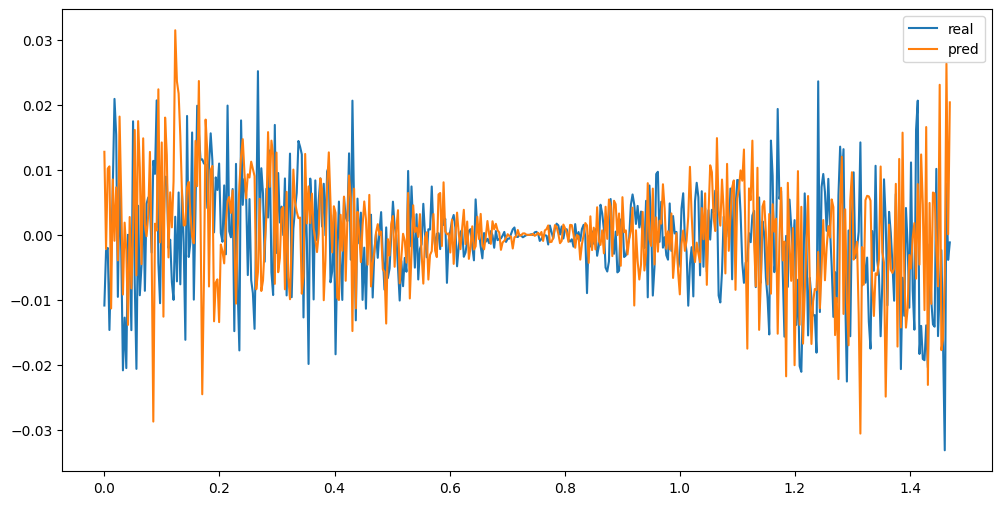

In [90]:
np.random.seed(0)

def reconstruir_senal(f, psd, t):

    # Convertir la PSD en la magnitud del espectro de frecuencia
    magnitud = np.sqrt(psd)

    # Crear un espectro complejo con magnitud y fase aleatoria
    
    fase_aleatoria = np.exp(1j * np.random.uniform(0, 2 * np.pi, len(f)))
    espectro = magnitud * fase_aleatoria

    # Duplicar el espectro para considerar las frecuencias negativas
    espectro_completo = np.concatenate([espectro, np.conj(espectro[::-1])])

    # Realizar la IFFT para obtener la señal en el dominio temporal
    senal = np.fft.ifft(espectro_completo)

    # Asegurar que la señal resultante sea real
    senal_real = np.real(senal)

    return senal_real[:len(t)]

rec_real = reconstruir_senal(f, Psd_real[100], t)
rec_pred = reconstruir_senal(f,psd_pred[100], t)
t_rec = t[0:502]


plt.figure(figsize=(12,6))
plt.plot(t_rec, rec_real, label='real')
plt.plot(t_rec, rec_pred, label='pred')
plt.legend()
plt.show()

# Umbral adaptativo

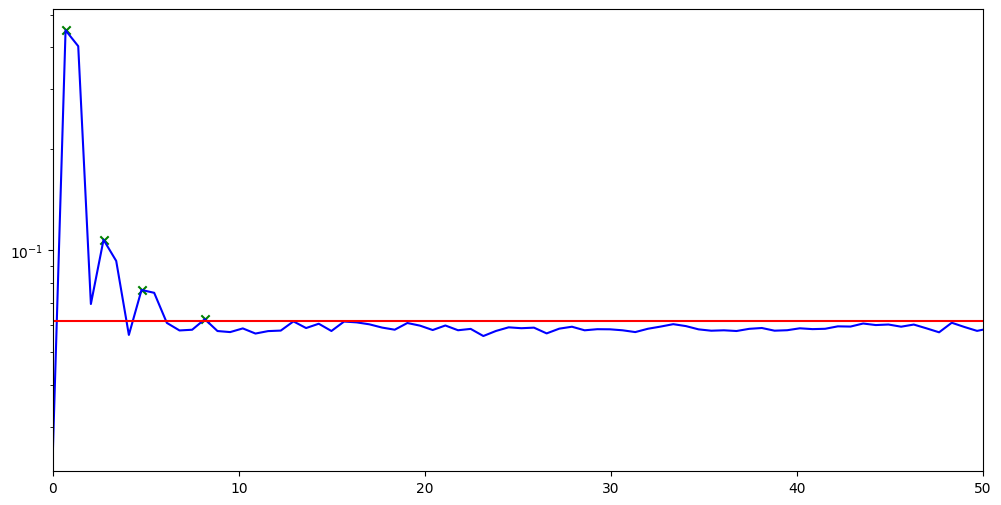

In [91]:
def thresholding_harmonics(f, psd):

    psd_mean = np.mean(psd)

    peaks, _ = sig.find_peaks(psd, height=psd_mean, distance=1)

    peaks_filtered = peaks[psd[peaks] > psd_mean] #filtrar picos
    # Paso 3: Obtener las coordenadas
    harm_f = f[peaks_filtered]
    harm_psd = psd[peaks_filtered]


    return psd_mean, harm_f, harm_psd


thres, harm_f, harm_psd = thresholding_harmonics(f, psd_pred[100])

plt.figure(figsize=(12,6))
plt.semilogy(f, psd_pred[100], c='b')
plt.semilogy(f, np.full(len(f), thres), c='r')
plt.scatter(harm_f, harm_psd,  marker='x', c='g')

plt.xlim([0,50])
plt.show()

# KDE Kernel density estimation

- Hallar el histograma de cada uno de los harmónicos.
- Hacerle KDE para una función limpia gaussiana

In [92]:
n_harm = 3
harmonics_vector = np.zeros((M, n_harm))

for i in range(M):
    thres, harm_f, harm_psd = thresholding_harmonics(f, psd_pred[i])
    harmonics_vector[i] = harm_psd
 
print(harmonics_vector.shape)
for i in range(n_harm):

    harmonic = harmonics_vector[:,i]
    kde = stats.gaussian_kde(harmonic)
    x = np.linspace(np.min(harmonic), np.max(harmonic), 1000)
    pdf = kde(x)
    plt.figure(figsize=(12, 6))
    plt.hist(harmonic, bins=100, density=True, alpha=0.6, color='b', label='Histogram')
    plt.plot(x, pdf, c='r', label='KDE PDF')
    plt.xlabel('Frequency (Hz)') 
    plt.ylabel('Density')
    plt.legend()
    plt.show()

ValueError: could not broadcast input array from shape (6,) into shape (3,)

# Señal reconstruida mediante umbral

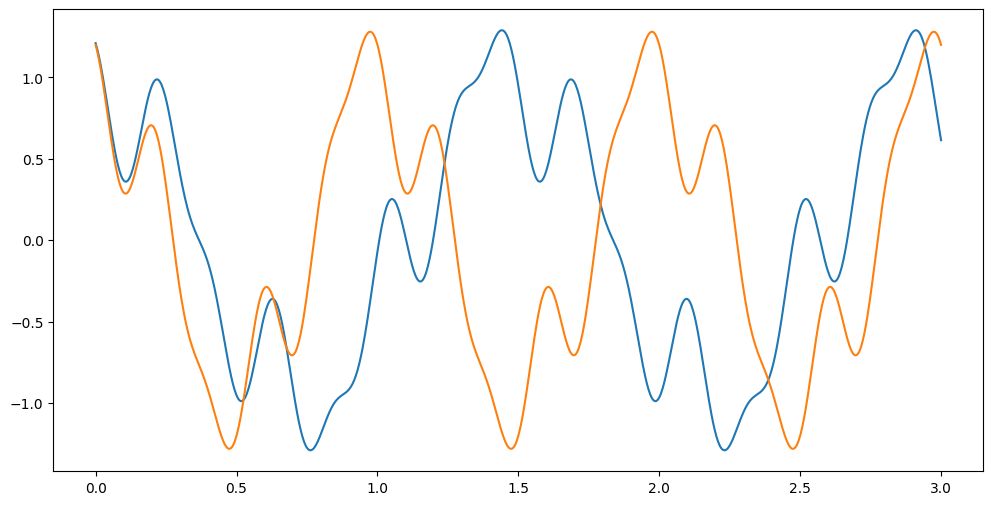

In [ ]:
psd_normalized = harm_psd/(harm_psd.max())
psd_vector = np.sqrt(psd_normalized)

#Reconstruir señal

rec_signal = psd_vector[0]*np.cos(2*np.pi*harm_f[0]*t) - psd_vector[1]*np.sin(2*np.pi*harm_f[1]*t) + psd_vector[2]*np.cos(2*np.pi*harm_f[2]*t)

plt.figure(figsize=(12,6))
plt.plot(t, rec_signal)
plt.plot(t, real_signal(t,wo))
plt.show()

# Error de reconstrucción Detección de picos vs Reconstrucción NN

In [ ]:
err_peaks = mean_squared_error(rec_signal, real_signal(t, wo))
print('error de reconstrucción por detección de picos mediante umbral: ', err_peaks)

err_NN = mean_squared_error(rec_pred, rec_real)
print('Error de reconstrucción por NN: ', err_NN)

error de reconstrucción por detección de picos mediante umbral:  1.2252768114885142
Error de reconstrucción por NN:  4.647152092977322e-06
